# Preparing input data for a ROMS simulation

If we want to build a `C-Star` blueprint from scratch, we first have to make the input data for our new ROMS simulation. The path to the input data files will then go into the C-Star blueprint.

In this guide, we prepare all the input data necessary for a ROMS simulation. This includes the 

* grid
* initial conditions
* tidal forcing
* surface forcing
* boundary forcing

Let's prepare these input data for the following simulation period: a week in mid-August 2012.

In [1]:
from datetime import datetime
start_time = datetime(2012, 8, 10, 12, 0, 0)  # noon on August 10, 2012
end_time = datetime(2012, 8, 17, 12, 0, 0)  # noon on August 17, 2012

We will save the input datasets in a designated target directory in our scratch directory.

In [2]:
import os
from pathlib import Path

In [3]:
target_dir = Path(os.getenv("PSCRATCH")) / "ROMS_TOOLS_INPUT_DATA"
target_dir

PosixPath('/pscratch/sd/n/nloose/ROMS_TOOLS_INPUT_DATA')

In [4]:
# Create the directory if it doesn't exist
target_dir.mkdir(exist_ok=True)

The generation of the ROMS input files is handled by a python package called [ROMS-Tools](https://roms-tools.readthedocs.io/en/latest/index.html), which is a dependency of `C-Star`.

In [5]:
import roms_tools

## Grid

In [6]:
from roms_tools import Grid

Let's make a new domain in the North Atlantic, one that surrounds Iceland.

In [7]:
%%time

grid = Grid(
    nx=30,  # number of points in the x-direction (not including 2 boundary cells on either end)
    ny=30,  # number of points in the y-direction (not including 2 boundary cells on either end)
    size_x=800,  # size of the domain in the x-direction (in km)
    size_y=800,  # size of the domain in the y-direction (in km)
    center_lon=-18,  # longitude of the center of the domain
    center_lat=65,  # latitude of the center of the domain
    rot=20,  # rotation of the grid's x-direction from lines of constant longitude, with positive values being a counter-clockwise rotation
    N = 20  # number of vertical layers
)

CPU times: user 1.33 s, sys: 77.9 ms, total: 1.41 s
Wall time: 3.21 s


To visualize the grid we have just created, we can use the `.plot` method.

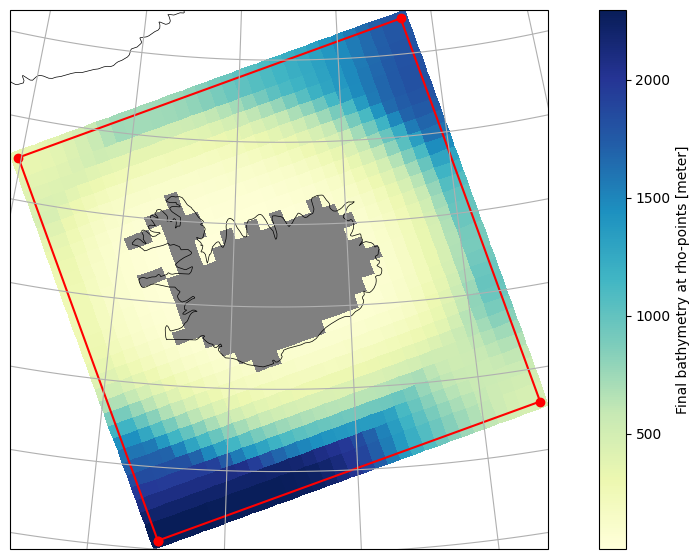

In [8]:
grid.plot(bathymetry=True)

We can also make a plot of the vertical coordinate system.

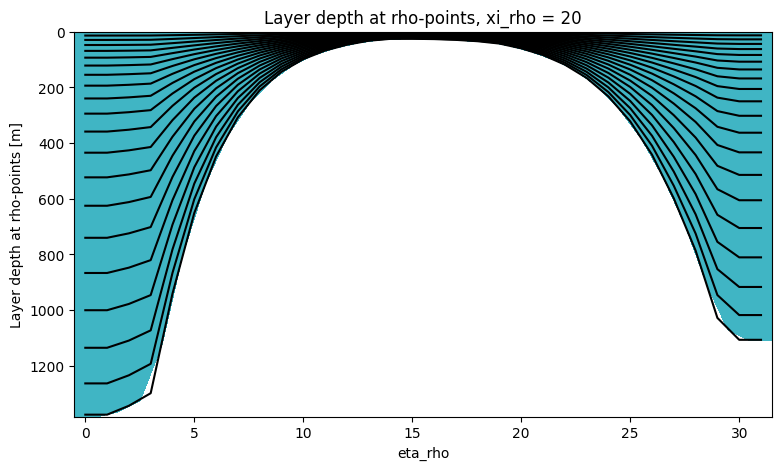

In [9]:
grid.plot_vertical_coordinate("layer_depth_rho", xi=20)

The big bump in the middle is Iceland!

To see the values of the grid variables, we can examine the `xarray.Dataset` object returned by the `.ds` property

In [10]:
grid.ds

<xarray.Dataset> Size: 603kB
Dimensions:              (eta_rho: 32, xi_rho: 32, xi_u: 31, eta_v: 31,
                          eta_coarse: 17, xi_coarse: 17, s_rho: 20, s_w: 21)
Coordinates: (12/14)
    lat_rho              (eta_rho, xi_rho) float64 8kB 60.16 60.26 ... 69.65
    lon_rho              (eta_rho, xi_rho) float64 8kB 337.5 338.0 ... 348.4
    lat_u                (eta_rho, xi_u) float64 8kB 60.21 60.3 ... 69.56 69.62
    lon_u                (eta_rho, xi_u) float64 8kB 337.8 338.2 ... 347.4 348.0
    lat_v                (eta_v, xi_rho) float64 8kB 60.27 60.36 ... 69.48 69.54
    lon_v                (eta_v, xi_rho) float64 8kB 337.5 337.9 ... 347.8 348.5
    ...                   ...
    layer_depth_rho      (s_rho, eta_rho, xi_rho) float32 82kB 2.202e+03 ... ...
    layer_depth_u        (s_rho, eta_rho, xi_u) float32 79kB 2.202e+03 ... 6.793
    layer_depth_v        (s_rho, eta_v, xi_rho) float32 79kB 2.202e+03 ... 6.793
    interface_depth_rho  (s_w, eta_rho, xi_rho) float32 86kB 2.294e+03 ... -0.0
    interface_depth_u    (s_w, eta_rho, xi_u) float32 83kB 2.294e+03 ... -0.0
    interface_depth_v    (s_w, eta_v, xi_rho) float32 83kB 2.294e+03 ... -0.0
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v, eta_coarse,
                                xi_coarse, s_rho, s_w
Data variables: (12/13)
    angle                (eta_rho, xi_rho) float64 8kB 0.4133 0.4133 ... 0.259
    f                    (eta_rho, xi_rho) float64 8kB 0.0001262 ... 0.0001364
    pm                   (eta_rho, xi_rho) float64 8kB 3.754e-05 ... 3.754e-05
    pn                   (eta_rho, xi_rho) float64 8kB 3.758e-05 ... 3.758e-05
    spherical            |S1 1B b'T'
    mask_rho             (eta_rho, xi_rho) int32 4kB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    ...                   ...
    mask_v               (eta_v, xi_rho) int32 4kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1
    h                    (eta_rho, xi_rho) float64 8kB 2.294e+03 ... 1.778e+03
    angle_coarse         (eta_coarse, xi_coarse) float64 2kB 0.4118 ... 0.2604
    mask_coarse          (eta_coarse, xi_coarse) int32 1kB 1 1 1 1 1 ... 1 1 1 1
    Cs_r                 (s_rho) float32 80B -0.9579 -0.8615 ... -0.0002471
    Cs_w                 (s_w) float32 84B -1.0 -0.9114 ... -0.0009921 0.0
Attributes:
    title:               ROMS grid created by ROMS-Tools
    roms_tools_version:  1.6.2
    size_x:              800
    size_y:              800
    center_lon:          -18
    center_lat:          65
    rot:                 20
    topography_source:   ETOPO5
    hmin:                5.0
    theta_s:             5.0
    theta_b:             2.0
    hc:                  300.0

Once we are happy with our grid, we can save it as a netCDF file via the `.save` method:

In [11]:
grid.save(target_dir / "roms_grd.nc")

[PosixPath('/pscratch/sd/n/nloose/ROMS_TOOLS_INPUT_DATA/roms_grd.nc')]

We can also export the grid parameters to a YAML file. This gives us a more storage-effective way to save and share input data made with `ROMS-Tools`. The YAML file can be used to recreate the same object later, and is compatible with both `ROMS-Tools` and `C-Star`.

In [12]:
yaml_filepath = target_dir / "roms_grd.yaml"
grid.to_yaml(yaml_filepath)

These are the contents of the written YAML file.

In [13]:
# Open and read the YAML file
with open(yaml_filepath, "r") as file:
    file_contents = file.read()

# Print the contents
print(file_contents)

---
roms_tools_version: 1.6.2
---
Grid:
  nx: 30
  ny: 30
  size_x: 800
  size_y: 800
  center_lon: -18
  center_lat: 65
  rot: 20
  N: 20
  theta_s: 5.0
  theta_b: 2.0
  hc: 300.0
  topography_source: ETOPO5
  hmin: 5.0



You can find more information about creating, plotting, and saving grids with `ROMS-Tools` [here](https://roms-tools.readthedocs.io/en/latest/grid.html).

## Initial Conditions

In [14]:
from roms_tools import InitialConditions

Here, we want to prepare a simulation in which we run ROMS with MARBL biogeochemistry (BGC), so we need to prepare both physical and BGC initial conditions. We create physical and BGC initial conditions **together** because ROMS needs a **single** initial conditions file. We use

* **GLORYS data** to create our physical initial conditions, i.e., temperature, salinity, sea surface height, and velocities
* a **biogeochemical (BGC) CESM climatology** to create our BGC initial conditions

In [15]:
glorys_path = "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120810.nc"
cesm_interior_path = "/global/cfs/projectdirs/m4746/Datasets/CESM_REGRIDDED/CESM-climatology_lowres_regridded.nc"

You can also download the GLORYS data yourself from https://www.mercator-ocean.eu/en/ocean-science/glorys/.

In [16]:
%%time
initial_conditions = InitialConditions(
    grid=grid,
    ini_time=start_time,
    source={"name": "GLORYS", "path": glorys_path},
    bgc_source={
        "name": "CESM_REGRIDDED",
        "path": cesm_interior_path,
        "climatology": True,
    },  # bgc_source is optional
    use_dask=False
)

INFO - Selected time entry closest to the specified start_time (2012-08-10 12:00:00) within the range [2012-08-10 12:00:00, 2012-08-11 12:00:00]: ['2012-08-10T12:00:00.000000000']


CPU times: user 3min 5s, sys: 1.89 s, total: 3min 7s
Wall time: 15.9 s


Including BGC initial conditions is optional. If you would like to only create physical intial conditions, you can skip the `bgc_source` argument, see also the [ROMS-Tools documentation](https://roms-tools.readthedocs.io/en/latest/initial_conditions.html).

To see the values of the intial conditions variables we can examine the `xarray.Dataset` object returned by the `.ds` property.

In [17]:
initial_conditions.ds

<xarray.Dataset> Size: 3MB
Dimensions:      (ocean_time: 1, eta_rho: 32, xi_rho: 32, s_rho: 20, xi_u: 31,
                  eta_v: 31, s_w: 21)
Coordinates:
    abs_time     (ocean_time) datetime64[ns] 8B 2012-08-10T12:00:00
  * ocean_time   (ocean_time) float64 8B 3.979e+08
Dimensions without coordinates: eta_rho, xi_rho, s_rho, xi_u, eta_v, s_w
Data variables: (12/42)
    zeta         (ocean_time, eta_rho, xi_rho) float32 4kB -0.6053 ... -0.8647
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 82kB 3.113 ... ...
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float32 82kB 34.96 ... ...
    u            (ocean_time, s_rho, eta_rho, xi_u) float32 79kB 0.02931 ... ...
    v            (ocean_time, s_rho, eta_v, xi_rho) float32 79kB 0.01259 ... ...
    ubar         (ocean_time, eta_rho, xi_u) float32 4kB 0.02655 ... -0.001648
    ...           ...
    diazFe       (ocean_time, s_rho, eta_rho, xi_rho) float32 82kB -4.748e-09...
    spCaCO3      (ocean_time, s_rho, eta_rho, xi_rho) float32 82kB 0.0001279 ...
    zooC         (ocean_time, s_rho, eta_rho, xi_rho) float32 82kB 0.3032 ......
    w            (ocean_time, s_w, eta_rho, xi_rho) float32 86kB 0.0 0.0 ... 0.0
    Cs_r         (s_rho) float32 80B -0.9579 -0.8615 ... -0.002245 -0.0002471
    Cs_w         (s_w) float32 84B -1.0 -0.9114 -0.809 ... -0.0009921 0.0
Attributes:
    title:                 ROMS initial conditions file created by ROMS-Tools
    roms_tools_version:    1.6.2
    ini_time:              2012-08-10 12:00:00
    model_reference_date:  2000-01-01 00:00:00
    source:                GLORYS
    bgc_source:            CESM_REGRIDDED
    theta_s:               5.0
    theta_b:               2.0
    hc:                    300.0

Here is a plot of the uppermost layer of the temperature field.

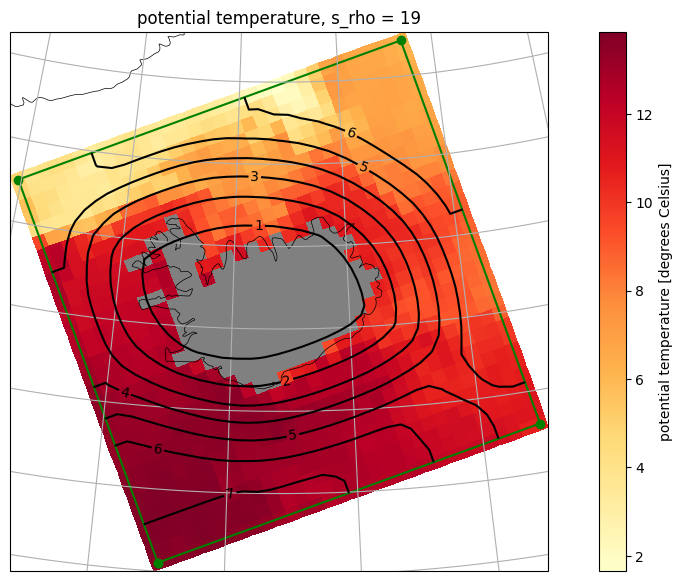

In [18]:
initial_conditions.plot("temp", s=-1, depth_contours=True)

We can also plot vertical sections of our initial conditions, for example alkalinity.

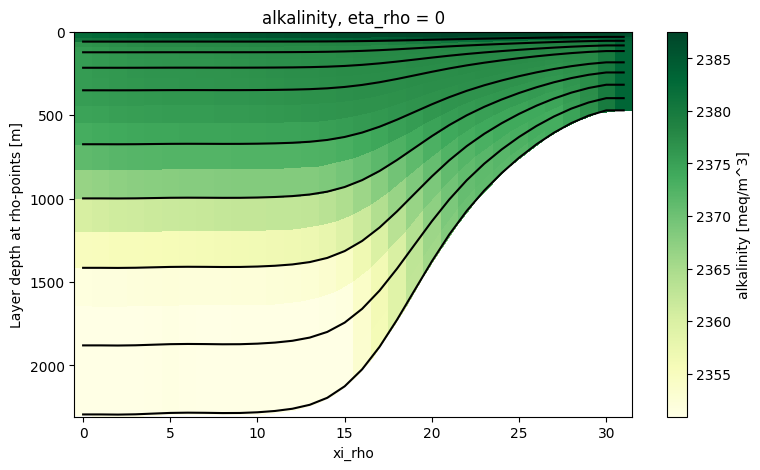

In [19]:
initial_conditions.plot("ALK", eta=0, layer_contours=True)

We can now save the dataset as a NetCDF and YAML file.

In [20]:
initial_conditions.save(target_dir / "roms_ini.nc")

[PosixPath('/pscratch/sd/n/nloose/ROMS_TOOLS_INPUT_DATA/roms_ini.nc')]

In [21]:
initial_conditions.to_yaml(target_dir / "roms_ini.yaml")

You can find more information about creating, plotting, and saving initial conditions with `ROMS-Tools` [here](https://roms-tools.readthedocs.io/en/latest/initial_conditions.html).

## Tidal Forcing

Next, we create tidal forcing for our domain.

In [22]:
from roms_tools import TidalForcing

The tidal forcing is based on the TPXO atlas, which sits on perlmutter at the following location.

In [23]:
tpxo_path = Path("/global/cfs/projectdirs/m4746/Datasets/TPXO/tpxo9.v2a.nc")

You can also download your own version from https://www.tpxo.net/global. Note that `ROMS-Tools` currently only supports the TPXO9v2 version.

In [24]:
%%time

tidal_forcing = TidalForcing(
    grid=grid,
    source={"name": "TPXO", "path": tpxo_path},
    ntides=10,  # number of constituents to consider <= 14. Default is 10.
    use_dask=False
)

CPU times: user 45.4 s, sys: 919 ms, total: 46.4 s
Wall time: 8.23 s


To see the values of the tidal forcing variables we can examine the `xarray.Dataset` object returned by the `.ds` property.

In [25]:
tidal_forcing.ds

<xarray.Dataset> Size: 323kB
Dimensions:  (ntides: 10, eta_rho: 32, xi_rho: 32, xi_u: 31, eta_v: 31)
Coordinates:
    omega    (ntides) float64 80B 0.0001405 0.0001454 ... 2.639e-06 5.323e-06
Dimensions without coordinates: ntides, eta_rho, xi_rho, xi_u, eta_v
Data variables:
    ssh_Re   (ntides, eta_rho, xi_rho) float32 41kB 0.6173 0.6247 ... -0.0198
    ssh_Im   (ntides, eta_rho, xi_rho) float32 41kB -0.4568 ... -0.007206
    pot_Re   (ntides, eta_rho, xi_rho) float32 41kB 0.05192 ... -0.0007893
    pot_Im   (ntides, eta_rho, xi_rho) float32 41kB 0.008197 ... 0.002649
    u_Re     (ntides, eta_rho, xi_u) float32 40kB -0.01072 ... 8.424e-05
    v_Re     (ntides, eta_v, xi_rho) float32 40kB 0.02044 0.02003 ... 0.00015
    u_Im     (ntides, eta_rho, xi_u) float32 40kB 0.006649 ... -1.048e-05
    v_Im     (ntides, eta_v, xi_rho) float32 40kB -0.007885 ... -0.0001538
Attributes:
    title:                 ROMS tidal forcing created by ROMS-Tools
    roms_tools_version:    1.6.2
    source:                TPXO
    model_reference_date:  2000-01-01 00:00:00
    allan_factor:          2.0

We can also plot any of the tidal forcing fields via the `.plot` method.

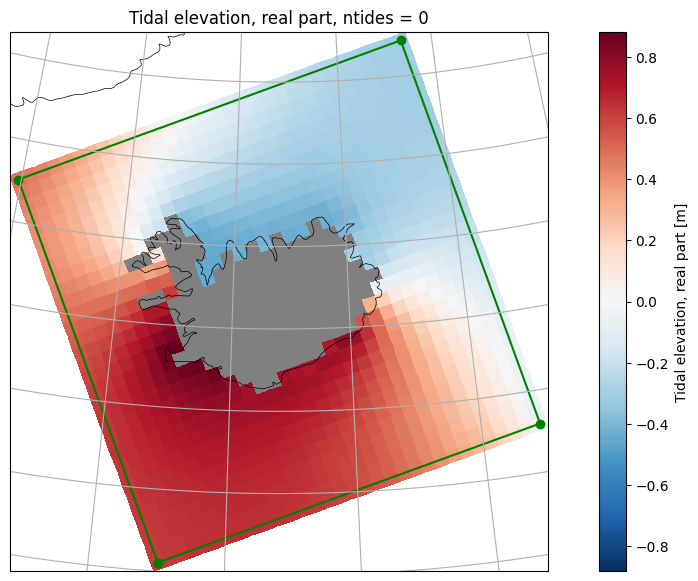

In [26]:
tidal_forcing.plot("ssh_Re", ntides=0)

Finally, we can save our tidal forcing as a netCDF file via the `.save` method.

In [27]:
tidal_forcing.save(target_dir / "roms_tides.nc")

[PosixPath('/pscratch/sd/n/nloose/ROMS_TOOLS_INPUT_DATA/roms_tides.nc')]

Again, we can also export the parameters of our `TidalForcing` object to a YAML file.

In [28]:
tidal_forcing.to_yaml(target_dir / "roms_tides.yaml")

You can find more information about creating, plotting, and saving tidal forcing with `ROMS-Tools` [here](https://roms-tools.readthedocs.io/en/latest/tides.html).

## Surface Forcing
Next, we create the surface forcing for our domain.

In [29]:
from roms_tools import SurfaceForcing

`ROMS-Tools` can create two types of surface forcing:

* **physical surface forcing** like 10m wind, shortwave radiation, and air temperature at 2m
* **biogeochemical (BGC) surface forcing** like atmospheric pCO2

Unlike initial conditions data, ROMS can read multiple surface forcing files, so we create these two types separately.

### Physical Surface Forcing

In this subsection, we use ERA5 data to create our physical surface forcing. Our downloaded ERA5 data sits at the following location on perlmutter.

In [30]:
era5_path = Path("/global/cfs/projectdirs/m4746/Datasets/ERA5/NA/2012/ERA5_2012-08.nc")

Note that the ERA5 data can also be found online at the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/).

We now create an instance of the `SurfaceForcing` class with `type = "physics"`.

In [31]:
%%time
surface_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "ERA5", "path": era5_path},
    correct_radiation=True, 
    type="physics",
    use_dask=False
)

CPU times: user 5min 10s, sys: 464 ms, total: 5min 10s
Wall time: 9.62 s


The surface forcing variables are held in an `xarray.Dataset` that is accessible via the `.ds` property.

In [32]:
surface_forcing.ds

<xarray.Dataset> Size: 5MB
Dimensions:   (time: 169, eta_rho: 32, xi_rho: 32)
Coordinates:
    abs_time  (time) datetime64[ns] 1kB 2012-08-10T12:00:00 ... 2012-08-17T12...
  * time      (time) float64 1kB 4.606e+03 4.606e+03 ... 4.612e+03 4.612e+03
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    swrad     (time, eta_rho, xi_rho) float32 692kB 249.2 234.9 ... 222.6 272.9
    lwrad     (time, eta_rho, xi_rho) float32 692kB 368.8 370.9 ... 341.3 335.0
    Tair      (time, eta_rho, xi_rho) float32 692kB 13.88 13.9 ... 7.3 7.292
    qair      (time, eta_rho, xi_rho) float32 692kB 0.009035 ... 0.006102
    rain      (time, eta_rho, xi_rho) float32 692kB 0.07277 0.1024 ... 0.003101
    uwnd      (time, eta_rho, xi_rho) float32 692kB 6.236 6.182 ... -3.38 -3.462
    vwnd      (time, eta_rho, xi_rho) float32 692kB 8.239 8.16 ... 1.51 1.503
Attributes:
    title:                 ROMS surface forcing file created by ROMS-Tools
    roms_tools_version:    1.6.2
    start_time:            2012-08-10 12:00:00
    end_time:              2012-08-17 12:00:00
    source:                ERA5
    correct_radiation:     True
    use_coarse_grid:       False
    model_reference_date:  2000-01-01 00:00:00
    type:                  physics

Since the ERA5 data comes at hourly frequency, `ROMS-Tools` has processed 169 time slices - a week worth of hourly surface forcing.

To visualize any of the surface forcing fields, we can use the `.plot` method.

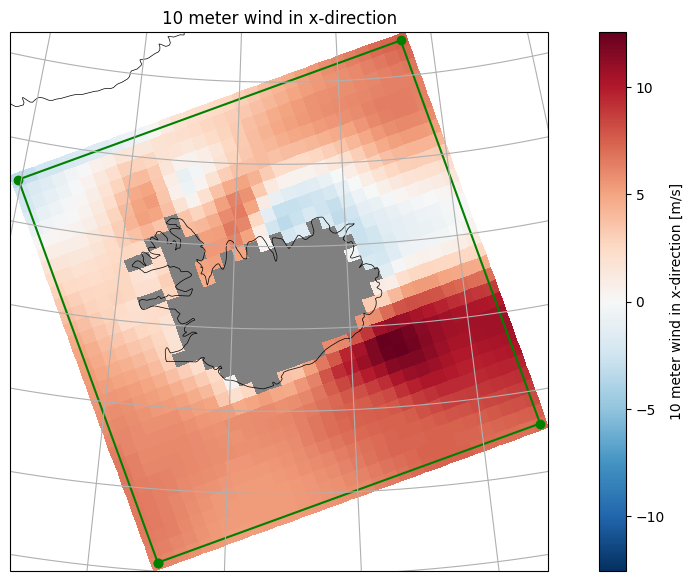

In [33]:
surface_forcing.plot("uwnd", time=0)

Let's save our physical surface forcing to NetCDF and YAML files.

In [34]:
surface_forcing.save(target_dir / "roms_frc.nc")

[PosixPath('/pscratch/sd/n/nloose/ROMS_TOOLS_INPUT_DATA/roms_frc.nc')]

In [35]:
surface_forcing.to_yaml(target_dir / "roms_frc.yaml")

### Biogeochemical (BGC) Surface Forcing
We now create BGC surface forcing. The BGC variables are interpolated from a CESM dataset with monthly frequency, which is located here.

In [36]:
cesm_surface_path = Path("/global/cfs/projectdirs/m4746/Datasets/CESM_REGRIDDED/CESM-surface_lowres_regridded.nc")

In [37]:
%%time

bgc_surface_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "CESM_REGRIDDED", "path": cesm_surface_path},
    type="bgc",
    use_dask=False
)

CPU times: user 114 ms, sys: 4.05 ms, total: 118 ms
Wall time: 396 ms


In [38]:
bgc_surface_forcing.ds

<xarray.Dataset> Size: 49kB
Dimensions:       (time: 2, eta_rho: 32, xi_rho: 32)
Coordinates:
    abs_time      (time) datetime64[ns] 16B 2012-08-01 2012-09-01
    pco2_time     (time) float64 16B 4.596e+03 4.627e+03
    iron_time     (time) float64 16B 4.596e+03 4.627e+03
    dust_time     (time) float64 16B 4.596e+03 4.627e+03
    nox_time      (time) float64 16B 4.596e+03 4.627e+03
    nhy_time      (time) float64 16B 4.596e+03 4.627e+03
Dimensions without coordinates: time, eta_rho, xi_rho
Data variables:
    pco2_air      (time, eta_rho, xi_rho) float32 8kB 314.8 313.8 ... 297.4
    pco2_air_alt  (time, eta_rho, xi_rho) float32 8kB 314.8 313.8 ... 297.4
    iron          (time, eta_rho, xi_rho) float32 8kB 5.547e-08 ... 9.885e-08
    dust          (time, eta_rho, xi_rho) float32 8kB 3.269e-12 ... 1.319e-11
    nox           (time, eta_rho, xi_rho) float32 8kB 2.078e-12 ... 1.45e-12
    nhy           (time, eta_rho, xi_rho) float32 8kB 1.186e-12 ... 4.717e-13
Attributes:
    title:                 ROMS surface forcing file created by ROMS-Tools
    roms_tools_version:    1.6.2
    start_time:            2012-08-10 12:00:00
    end_time:              2012-08-17 12:00:00
    source:                CESM_REGRIDDED
    correct_radiation:     False
    use_coarse_grid:       False
    model_reference_date:  2000-01-01 00:00:00
    type:                  bgc

The CESM data has monthly frequency, so `ROMS-Tools` has only processed two time slices.

We can plot the BGC surface forcing as we saw above.

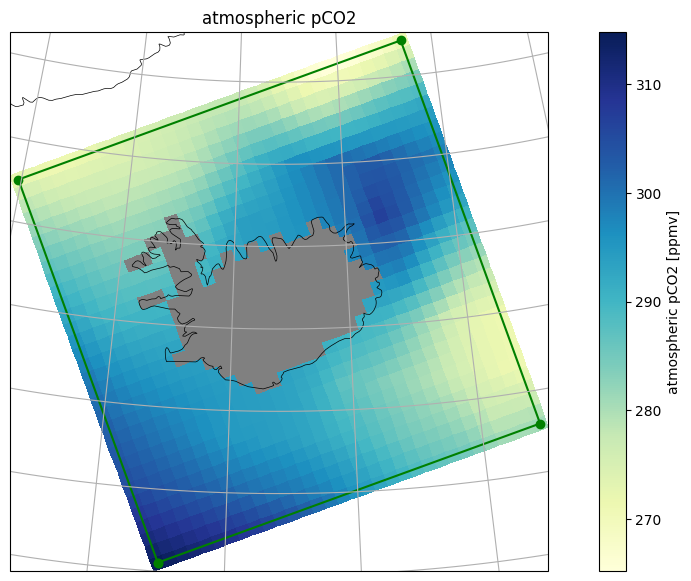

In [39]:
bgc_surface_forcing.plot("pco2_air", time=0)

Finally, we save our BGC surface forcing to NetCDF and YAML files.

In [40]:
bgc_surface_forcing.save(target_dir /"roms_frc_bgc.nc")

[PosixPath('/pscratch/sd/n/nloose/ROMS_TOOLS_INPUT_DATA/roms_frc_bgc.nc')]

In [41]:
bgc_surface_forcing.to_yaml(target_dir / "roms_frc_bgc.yaml")

You can find more information about creating, plotting, and saving surface forcing with `ROMS-Tools` [here](https://roms-tools.readthedocs.io/en/latest/surface_forcing.html).

## Boundary Forcing
The last input data necessary for ROMS is the boundary forcing (or, equivalently, the open boundary conditions).

In [42]:
from roms_tools import BoundaryForcing

`ROMS-Tools` can create two types of boundary forcing:

* **physical boundary forcing** like temperature, salinity, velocities, and sea surface height
* **biogeochemical (BGC) boundary forcing** like alkalinity, dissolved inorganic phosphate, etc.

As with surface forcing, ROMS accepts multiple boundary forcing files, so we create these two types separately.

### Physical boundary forcing

We use the same GLORYS data as above to create our physical boundary forcing.

We now create an instance of the `BoundaryForcing` class with `type = "physics"`.

Now we need a week worth of GLORYS data, so we have to update our `glorys_path`.

In [43]:
glorys_path = [
    Path("/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120809.nc"), # include data from day before start time
    Path("/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120810.nc"),
    Path("/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120811.nc"),
    Path("/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120812.nc"),
    Path("/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120813.nc"),
    Path("/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120814.nc"),
    Path("/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120815.nc"),
    Path("/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120816.nc"),
    Path("/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120817.nc"),
    Path("/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120818.nc") # include data from day after end time
]

Note that we could have also specified the data location via a wildcard, e.g., `glorys_path = "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/*.nc"`. But with this latter choice, `ROMS-Tools` can operate quite a bit slower (especially if you experiment with `use_dask = True`). More specific filenames are better!

In [44]:
%%time

boundary_forcing = BoundaryForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "GLORYS", "path": glorys_path},
    type="physics",  # "physics" or "bgc"; default is "physics"
    apply_2d_horizontal_fill=True,
    use_dask=False
)

CPU times: user 18min 15s, sys: 2.63 s, total: 18min 18s
Wall time: 19.2 s


The boundary forcing variables are held in an `xarray.Dataset` that is accessible via the `.ds` property.

In [45]:
boundary_forcing.ds

<xarray.Dataset> Size: 337kB
Dimensions:     (bry_time: 8, s_rho: 20, xi_u: 31, xi_rho: 32, eta_rho: 32,
                 eta_v: 31)
Coordinates:
    abs_time    (bry_time) datetime64[ns] 64B 2012-08-10T12:00:00 ... 2012-08...
  * bry_time    (bry_time) float64 64B 4.606e+03 4.606e+03 ... 4.612e+03
Dimensions without coordinates: s_rho, xi_u, xi_rho, eta_rho, eta_v
Data variables: (12/28)
    u_south     (bry_time, s_rho, xi_u) float32 20kB 0.02931 0.01553 ... 0.05322
    v_south     (bry_time, s_rho, xi_rho) float32 20kB 0.01259 ... 0.01006
    zeta_south  (bry_time, xi_rho) float32 1kB -0.6053 -0.6007 ... -0.4932
    temp_south  (bry_time, s_rho, xi_rho) float32 20kB 3.113 3.116 ... 11.34
    salt_south  (bry_time, s_rho, xi_rho) float32 20kB 34.96 34.95 ... 35.26
    ubar_south  (bry_time, xi_u) float32 992B 0.02655 -0.02214 ... 0.06859
    ...          ...
    v_west      (bry_time, s_rho, eta_v) float32 20kB 0.01259 ... 0.04785
    zeta_west   (bry_time, eta_rho) float32 1kB -0.6053 -0.6581 ... -0.5465
    temp_west   (bry_time, s_rho, eta_rho) float32 20kB 3.113 3.174 ... 2.878
    salt_west   (bry_time, s_rho, eta_rho) float32 20kB 34.96 34.96 ... 31.85
    ubar_west   (bry_time, eta_rho) float32 1kB 0.02655 -0.03006 ... 0.01929
    vbar_west   (bry_time, eta_v) float32 992B 0.0425 0.03434 ... -0.01109
Attributes:
    title:                 ROMS boundary forcing file created by ROMS-Tools
    roms_tools_version:    1.6.2
    start_time:            2012-08-10 12:00:00
    end_time:              2012-08-17 12:00:00
    source:                GLORYS
    model_reference_date:  2000-01-01 00:00:00
    theta_s:               5.0
    theta_b:               2.0
    hc:                    300.0

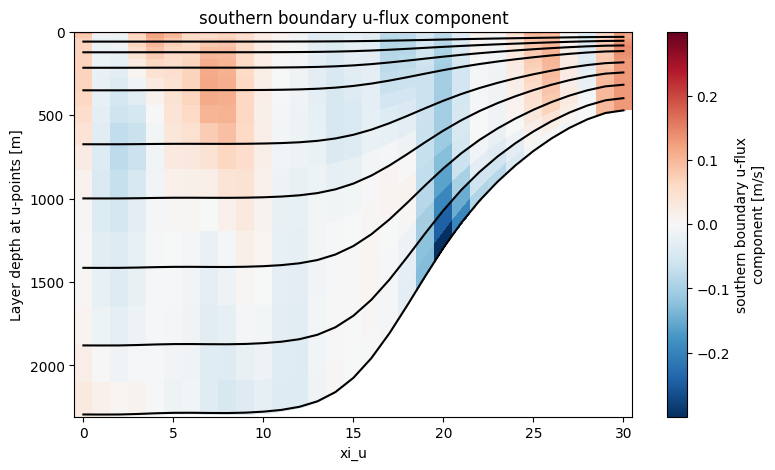

In [46]:
boundary_forcing.plot("u_south", time=0, layer_contours=True)

In [47]:
boundary_forcing.save(target_dir / "roms_bry.nc")

[PosixPath('/pscratch/sd/n/nloose/ROMS_TOOLS_INPUT_DATA/roms_bry.nc')]

In [48]:
boundary_forcing.to_yaml(target_dir / "roms_bry.yaml")

### Biogeochemical (BGC) boundary forcing
We now create BGC boundary forcing. The BGC variables are interpolated from the same CESM climatology as above.

In [49]:
%%time

bgc_boundary_forcing = BoundaryForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "CESM_REGRIDDED", "path": cesm_interior_path, "climatology": True},
    type="bgc",
    apply_2d_horizontal_fill=True,
    use_dask=False,
)

CPU times: user 28.3 s, sys: 3.83 s, total: 32.1 s
Wall time: 42.2 s


In [50]:
bgc_boundary_forcing.ds

<xarray.Dataset> Size: 4MB
Dimensions:            (bry_time: 12, s_rho: 20, xi_rho: 32, eta_rho: 32)
Coordinates:
    abs_time           (bry_time) datetime64[ns] 96B 2000-01-16 ... 2000-12-15
  * bry_time           (bry_time) float64 96B 15.0 45.0 74.0 ... 319.0 349.0
Dimensions without coordinates: s_rho, xi_rho, eta_rho
Data variables: (12/128)
    PO4_south          (bry_time, s_rho, xi_rho) float32 31kB 0.9482 ... 0.6587
    NO3_south          (bry_time, s_rho, xi_rho) float32 31kB 14.76 ... 10.59
    SiO3_south         (bry_time, s_rho, xi_rho) float32 31kB 11.7 ... 7.944
    NH4_south          (bry_time, s_rho, xi_rho) float32 31kB 0.001141 ... 0....
    Fe_south           (bry_time, s_rho, xi_rho) float32 31kB 0.0008401 ... 0...
    Lig_south          (bry_time, s_rho, xi_rho) float32 31kB 0.001601 ... 0....
    ...                 ...
    diazChl_west       (bry_time, s_rho, eta_rho) float32 31kB -1.136e-05 ......
    diazC_west         (bry_time, s_rho, eta_rho) float32 31kB -4.133e-05 ......
    diazP_west         (bry_time, s_rho, eta_rho) float32 31kB -2.961e-07 ......
    diazFe_west        (bry_time, s_rho, eta_rho) float32 31kB -3.104e-09 ......
    spCaCO3_west       (bry_time, s_rho, eta_rho) float32 31kB 0.001462 ... 0...
    zooC_west          (bry_time, s_rho, eta_rho) float32 31kB 0.2618 ... 1.026
Attributes:
    title:                 ROMS boundary forcing file created by ROMS-Tools
    roms_tools_version:    1.6.2
    start_time:            2012-08-10 12:00:00
    end_time:              2012-08-17 12:00:00
    source:                CESM_REGRIDDED
    model_reference_date:  2000-01-01 00:00:00
    theta_s:               5.0
    theta_b:               2.0
    hc:                    300.0
    climatology:           True

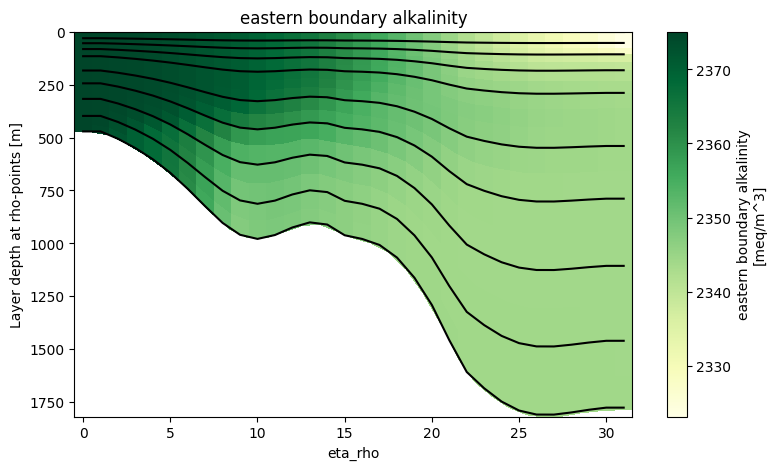

In [51]:
bgc_boundary_forcing.plot("ALK_east", time=0, layer_contours=True)

In [52]:
bgc_boundary_forcing.save(target_dir / "roms_bry_bgc.nc")

[PosixPath('/pscratch/sd/n/nloose/ROMS_TOOLS_INPUT_DATA/roms_bry_bgc.nc')]

In [53]:
bgc_boundary_forcing.to_yaml(target_dir / "roms_bry_bgc.yaml")

You can find more information about creating, plotting, and saving boundary forcing with `ROMS-Tools` [here](https://roms-tools.readthedocs.io/en/latest/boundary_forcing.html).

## Summary

We created the following NetCDF files:

* Grid: `target_dir/roms_grd.nc`
* Initial Conditions: `target_dir/roms_ini.nc`
* Tidal Forcing: `target_dir/roms_tides.nc`
* Physical Surface Forcing: `target_dir/roms_frc.nc`
* BGC Surface Forcing: `target_dir/roms_frc_bgc.nc`
* Physical Boundary Forcing: `target_dir/roms_bry.nc`
* BGC Boundary Forcing: `target_dir/roms_bry_bgc.nc`

We also created the following YAML files that can be used to re-create the exact same `ROMS-Tools` objects and NetCDF files:

* Grid: `target_dir/roms_grd.yaml`
* Initial Conditions: `target_dir/roms_ini.yaml`
* Tidal Forcing: `target_dir/roms_tides.yaml`
* Physical Surface Forcing: `target_dir/roms_frc.yaml`
* BGC Surface Forcing: `target_dir/rom_frc_bgc.yaml`
* Physical Boundary Forcing: `target_dir/roms_bry.yaml`
* BGC Boundary Forcing: `target_dir/roms_bry_bgc.yaml`

The paths to these input files (either the NetCDF files or the YAML files) can now be used to set up a ROMS simulation with `C-Star`.